## A spectral barotropic vorticity model

We're going to present a simple barotropic vorticity equation model. This is a 2-dimensional model of a homegeneous,  non-divergent, incompressible flow solved on the surface of a sphere. The governing equation is simply:

$\dfrac{\mathrm{D} \omega}{\mathrm{D} t} = 0$

where $\omega$ is the absolute vorticity. Given the spherical geometry of the problem, it is convenient to use a spectral method, representing the prognostic variables as finite summations of spherical harmonics.

## Why an object-oriented model

There are several advantages to implementing such a model using object-oriented programming. Firstly we can make clear our separation of concerns:

* A model object knows how to take an atmospheric state and evolve it according to some dynamical rules.
* A spectral transforms object knows how to transform fields bewteen grid and spectral space, and how to evaluate derivatives in spectral space.
* An output writer object knows how to take a model state and write it to an output file.

## Why an object-oriented model

A second advantage of the object-oriented design is that we can encapsulate the model state within an object. This means we can construct multiple model instances with different inputs and configurations, and they can never interfere with one another.

These design concepts make running experiments with the model simple too (think of running experiments as another separated concern).

# Tour of the model

# Running barotropic models

In this notebook we'll run a couple of different barotropic model configurations and write their output to NetCDF files.

We won't have to change any of the code in the `barotropic` package. We can create multiple independent model instances, because all model state is stored within the model instance (i.e., no global state in the `barotropic` module).

The first job is to import the modules/objects we'll need:

In [1]:
# first install 
# conda create -n barotropic -c conda-forge pyspharm numpy netcdf4 jupyterlab xarray matplotlib 
# optional cartopy for map displays here, or use IDV on output files

In [2]:
from datetime import datetime

import netCDF4
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
# import cartopy to put coastlines on plots 

from barotropic.model import BarotropicModel
from barotropic.io import NetCDFWriter

Before we start creating models we'll just create a few variables to control how long we run each model for and how often we write output to file. Both models will be run for 5 days and write output every 6 hours:

In [3]:
hour = 3600
run_time = 5 * 24 * hour 
output_interval = 6 * hour

### An idealized initial condition

The first model we'll run uses an idealized initial condition as in Held (1985).
The initial vorticity is derived from a zonal wind:
    
$u(\theta) = 25 \cos(\theta)\, - 30 \cos^3(\theta) + 300 \sin^2(\theta)\,\cos^6(\theta)$

where $\theta$ is latitude. The associated vorticity (assuming zero meridional flow) is computed and the following perturbation is added:

$\zeta^\prime = \dfrac{A}{2}\, \cos (\theta) \, \exp{\left[-\left((\theta - \theta_0)/\theta_w\right)^2\right]} \, \cos (m \lambda)$

with $m = 4$, $\theta_0 = 45^\circ\textrm{N}$, $\theta_w = 15^\circ$, and $A = 8\times 10^{-5}$, and where $\lambda$ is longitude.

To save time and effort, this initial condition has been pre-generated on an N64 Gaussian grid, and is contained in the NumPy save file `input_data/idealized.npy`.

We can load this file using `np.load`, determine the grid size and work out a good trunction:

In [4]:
vrt = np.load('input_data/idealized.npy')
nlat, nlon = vrt.shape
truncation = nlon // 3

Next we can create a barotropic model using this initial condition.
For this model resolution a time-step of 1800 seconds is a good enough choice.
We'll pick an arbitrary start date, it doesn't mean anything in this case.

In [5]:
dt = 1800
start_time = datetime(2000, 1, 1)
model_ideal = BarotropicModel(vrt, truncation, dt, start_time)

We want to run this model, saving output every 3 hours.
For this we're going to need a way to write model data to file.

Within the `barotropic.io` module is a class called `NetCDFWriter` that we can use for this.
It is already imported so we can go ahead and use it, it takes a model and a filename as input.

In [6]:
saver_ideal = NetCDFWriter(model_ideal, 'model_idealized.nc',overwrite=True)

Later we can call the `save()` method of the `NetCDFWriter` to save model state to file:

Now we have both a model and a saver we can run the model.

The model object has a method called `run_with_snapshots()` which allows us to run a model for a specified amount of time, pausing at specified intervals.

We can tell the model to pause every 3 hours and during this pause we can write output using our saver:

In [7]:
# The run_with_snapshots method is an iterator that yields the
# current model time at the given interval. This means we can
# loop over the iterator saving the current model state.
for t in model_ideal.run_with_snapshots(
        run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(model_ideal.valid_time))
    saver_ideal.save()
    
# Make sure the output file is closed when we are done:
saver_ideal.close()

Saving output at time: 2000-01-01 06:00:00
Saving output at time: 2000-01-01 12:00:00
Saving output at time: 2000-01-01 18:00:00
Saving output at time: 2000-01-02 00:00:00
Saving output at time: 2000-01-02 06:00:00
Saving output at time: 2000-01-02 12:00:00
Saving output at time: 2000-01-02 18:00:00
Saving output at time: 2000-01-03 00:00:00
Saving output at time: 2000-01-03 06:00:00
Saving output at time: 2000-01-03 12:00:00
Saving output at time: 2000-01-03 18:00:00
Saving output at time: 2000-01-04 00:00:00
Saving output at time: 2000-01-04 06:00:00
Saving output at time: 2000-01-04 12:00:00
Saving output at time: 2000-01-04 18:00:00
Saving output at time: 2000-01-05 00:00:00
Saving output at time: 2000-01-05 06:00:00
Saving output at time: 2000-01-05 12:00:00
Saving output at time: 2000-01-05 18:00:00
Saving output at time: 2000-01-06 00:00:00


We now have a file `'model_idealized.nc'` that contains our model output:

In [8]:
output = xr.open_dataset('model_idealized.nc')
output

<xarray.Dataset>
Dimensions:             (time: 20, latitude: 128, longitude: 256)
Coordinates:
  * time                (time) datetime64[ns] 2000-01-01T06:00:00 ... 2000-01-06
  * latitude            (latitude) float32 88.93 87.54 86.14 ... -87.54 -88.93
  * longitude           (longitude) float32 0.0 1.406 2.812 ... 357.2 358.6
Data variables:
    latitude_longitude  int32 ...
    uwnd                (time, latitude, longitude) float32 ...
    vwnd                (time, latitude, longitude) float32 ...
    vrt                 (time, latitude, longitude) float32 ...

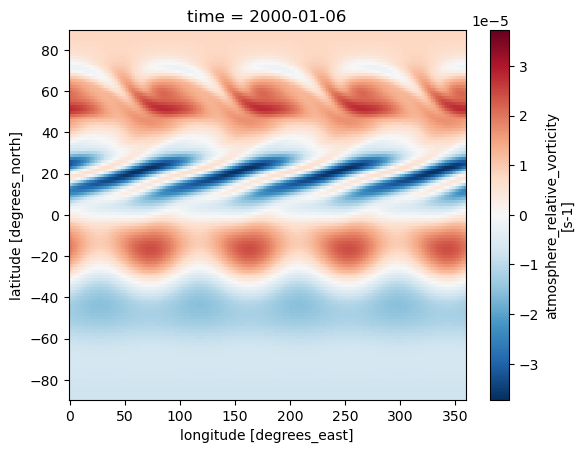

In [9]:
output.vrt[-1].plot()

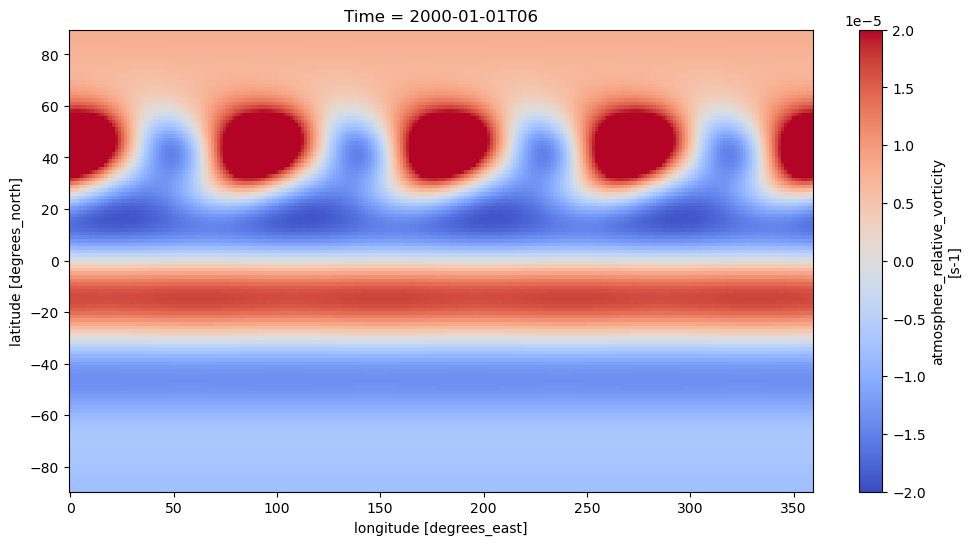

In [10]:
# from https://climate-cms.org/posts/2019-09-03-python-animation.html
tas = output.vrt # to match the code exactly from example

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-0.00002, vmax=0.00002,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=20,       # Could also be iterable or list
    interval=200     # ms between frames
)

HTML(ani.to_jshtml())

### A realistic initial condition

We can also run the barotropic model with a more realistic initial condition.

We'll set up a second model that is initialized using vorticity from ECMWF analysis valid at 2016-11-01 0000z.
This initial condition is stored in the NetCDF file `input_data/ecmwf.201611010000.nc`.

This file contains data on an N80 Gaussian grid, corresponding to a spectral resolution of T106.
This is higher resolution than the previous model, so we'll need to make the time-step shorter:

In [17]:
# Load initial condition from file:
ds = netCDF4.Dataset('input_data/ecmwf.201611010000.nc')
vrt = ds.variables['atmosphere_relative_vorticity'][:]
nlat, nlon = vrt.shape
truncation = nlon // 3

# Use a shorter 900 second time-step and the correct start time:
dt = 900
start_time = datetime(2016, 11, 1, 0)

# Create the model and a saver:
model_ecmwf = BarotropicModel(vrt, truncation, dt, start_time)
saver_ecmwf = NetCDFWriter(model_ecmwf, 'output_ecmwf2.nc')

# Run the model (same method as before)
for t in model_ecmwf.run_with_snapshots(
        run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(model_ecmwf.valid_time))
    saver_ecmwf.save()
saver_ecmwf.close()

Saving output at time: 2016-11-01 06:00:00
Saving output at time: 2016-11-01 12:00:00
Saving output at time: 2016-11-01 18:00:00
Saving output at time: 2016-11-02 00:00:00
Saving output at time: 2016-11-02 06:00:00
Saving output at time: 2016-11-02 12:00:00
Saving output at time: 2016-11-02 18:00:00
Saving output at time: 2016-11-03 00:00:00
Saving output at time: 2016-11-03 06:00:00
Saving output at time: 2016-11-03 12:00:00
Saving output at time: 2016-11-03 18:00:00
Saving output at time: 2016-11-04 00:00:00
Saving output at time: 2016-11-04 06:00:00
Saving output at time: 2016-11-04 12:00:00
Saving output at time: 2016-11-04 18:00:00
Saving output at time: 2016-11-05 00:00:00
Saving output at time: 2016-11-05 06:00:00
Saving output at time: 2016-11-05 12:00:00
Saving output at time: 2016-11-05 18:00:00
Saving output at time: 2016-11-06 00:00:00


In [18]:
vrt

masked_array(
  data=[[-7.82054849e-06, -7.55232759e-06, -7.26920553e-06, ...,
         -7.40331598e-06, -7.53742643e-06, -7.68643804e-06],
        [ 3.69872432e-05,  3.58100515e-05,  3.46328598e-05, ...,
          3.65849119e-05,  3.67190223e-05,  3.68531328e-05],
        [-2.44204421e-05, -2.06206460e-05, -1.68357510e-05, ...,
         -3.32270283e-05, -3.02914996e-05, -2.73559708e-05],
        ...,
        [ 4.81035095e-05,  5.03535848e-05,  5.25887590e-05, ...,
          3.10416799e-05,  3.67339235e-05,  4.24112659e-05],
        [-4.86944336e-05, -4.58483119e-05, -4.29872889e-05, ...,
         -4.85156197e-05, -4.85752244e-05, -4.86348290e-05],
        [-1.80576462e-05, -1.88176055e-05, -1.95775647e-05, ...,
         -1.51072163e-05, -1.60906930e-05, -1.70741696e-05]],
  mask=False,
  fill_value=1e+20)

In [32]:
start_time = xr.open_dataset('input_data/ecmwf.201611010000.nc').time.data

In [49]:
start_time.astype(str)

'2016-11-01T00:00:00.000000000'

In [52]:
import pandas as pd
pd.to_datetime(start_time)

Timestamp('2016-11-01 00:00:00')

# Animate the results

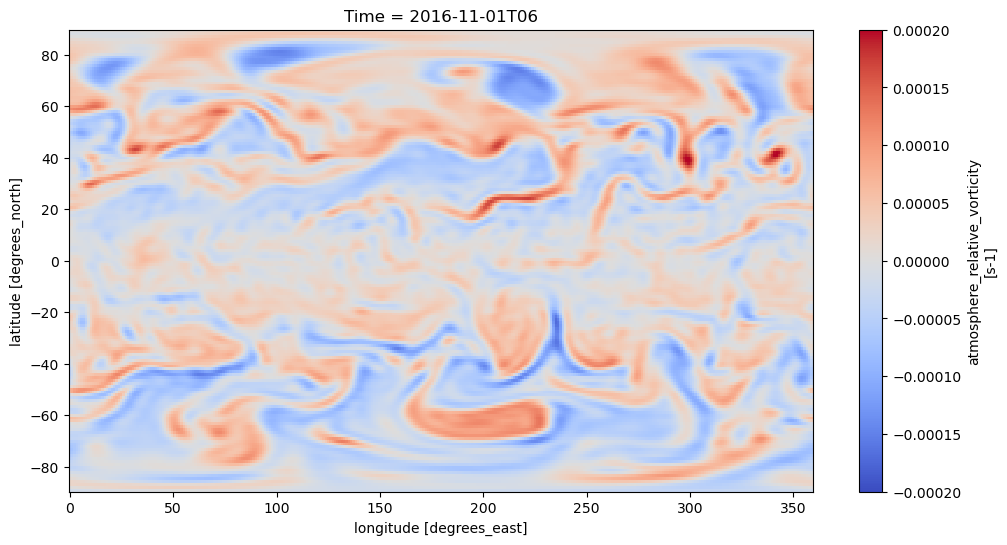

In [14]:
# from https://climate-cms.org/posts/2019-09-03-python-animation.html
tas = df.vrt # to match the code exactly from example

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-0.0002, vmax=0.0002,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=20,       # Could also be iterable or list
    interval=200     # ms between frames
)

HTML(ani.to_jshtml())